<a href="https://colab.research.google.com/github/davepoppins5073/Proj_Auto_Trading_Bot/blob/main/LSTM_predicting_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs
### (Note: These are left commented out but for actual use please uncomment and run)

In [ ]:
#!pip install panel==0.12.6 hvplot==0.7.3
#!pip install yfinance
#!pip install finance-calculator
#!pip install 'fsspec>=0.3.3'
#!pip install streamlit

# Libraries and Imports

#### (Note:  While not all the libraries and imports are used in this version of this script they are integral to the continued development of our code base surrounding the greater application we are building.

In [ ]:
# 1. Basic Python Imports
import pandas as pd
import numpy as np
import os
from pathlib import Path

# 2. Pandas_Datareader
import pandas_datareader.data as web
from pandas_datareader import data, wb
import pandas_datareader as pdr

# 3. Date Time
import datetime as dt
from datetime import datetime

# 4. Plotting
import plotly
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 5. Stats
from scipy.stats import linregress

# 6. Machine Learning
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


In [ ]:
def open_price_df(digital_asset):

  """
  open_price_df:  this function takes a list of tickers/stock symbols and returns a dataframe of the stock(s) open prices
  from 11/1/2018 to present through the use of the yahoo API.
  
  """

    # Date information 
    startdate = datetime(2018,1,1)
    enddate = datetime.today() 
    
    # API PULL to get Data for coins
    open_df = web.DataReader(digital_asset, 'yahoo', startdate, enddate)
   

    return(open_df)

## CODE:



### <i>About pandasdatareader</i> & <i>google collab:</i>
Due to issues with the M1 chip in the MacBook laptops, it was decided to move the LSTM code to Google Colab. It was discovered that pandasdatatreader using yahoo finance as a data source doesnt work on Colab. We then created two csv with stock data for PGR as an example. 

## <b>Files:</b>

1.   <u>pgr_data.csv</u> - open prices from 2018 to 61 days before we started the prediction (training set of data)
2.   <u>pgr_data_test.csv</u> - open prices for the predicted date ranges



In [3]:
# UPLOADING PGR TESTING DATA:

#from google.colab import files
csv_file = files.upload()


NameError: ignored

In [ ]:

# Read the applicants_data.csv file from the Resources folder into a Pandas DataFrame
test_stock_df = pd.read_csv("pgr_data.csv")

# Review the DataFrame
test_stock_df.head()


,Date,Adj Close,Close,High,Low,Open,Volume
0,2012-01-03,13.235171,19.340000,19.969999,19.280001,19.809999,4402700.0
1,2012-01-04,13.180425,19.260000,19.330000,19.200001,19.280001,9985500.0
2,2012-01-05,13.296759,19.430000,19.450001,19.010000,19.160000,3718900.0
3,2012-01-06,13.351509,19.510000,19.770000,19.400000,19.410000,3224100.0
4,2012-01-09,13.378881,19.549999,19.629999,19.420000,19.490000,10015200.0


In [ ]:
# DEFINING THE TRAINING DATA SET

training_set2 = test_stock_df.iloc[:,4:5].values
print(training_set2)
print(training_set2.shape)

[[ 19.28000069]
 [ 19.20000076]
 [ 19.01000023]
 ...
 [118.16999817]
 [117.19000244]
 [117.93000031]]
(2622, 1)


## Data Pre-processing:
sklearn.preprocessing.MinMaxScaler: 
We use the sklearn MinMaxScaler to normalize the data i.e. have all the data to be in the region of 0 and 1 

<b>Why ?</b>
... according to this [source](https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/)
<p>"Many machine learning algorithms perform better when numerical input variables are scaled to a standard range. The two most popular techniques for scaling numerical data prior to modeling are normalization and standardization. Normalization scales each input variable separately to the range 0-1, which is the range for floating-point values where we have the most precision."</p>


In [ ]:
# sklearn MinMaxScaler documentation: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range =(0,1))
scaled_training_set = scaler.fit_transform(training_set2)

display(scaled_training_set[:5])
display(len(scaled_training_set))
display(type(scaled_training_set))

array([[0.00272288],
       [0.0019161 ],
       [0.        ],
       [0.00393303],
       [0.00413473]])

2622

numpy.ndarray

In [ ]:
# Initializing the X_train and y_train list and then will use a for-loop to populate them both 
# with the correct dates and values. 

X_train = []
y_train = []

for i in range(60,len(scaled_training_set)):
  X_train.append(scaled_training_set[i-60: i, 0])
  y_train.append(scaled_training_set[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)




(2562, 60)
(2562,)


In [ ]:
# The data is converted to a 3D array:convert the data into a 3D array with 
# 1) X_train samples 2) 60 timestamps, and 3) one feature at each step. 60 timestamps.
X_train = np.reshape(X_train, newshape=(
    X_train.shape[0],
    X_train.shape[1],
    1)
                    ) ## End of parenthesed
                     
X_train.shape



(2562, 60, 1)

## Creating the LSTM Model

<p> The LSTM layer is added with the following arguments:  
1.   <b>50 units</b> is the dimensionality of the output space,
2.   <b>return_sequences=True</b> is necessary for stacking LSTM layers so the consequent LSTM layer has a three-dimensional sequence input
3.   <b>Input_shape</b> is the shape of the training dataset.

<i>Specifying 0.2 in the Dropout layer means that 20% of the layers will be dropped. Following the LSTM and Dropout layers, we add the Dense layer that specifies an output of one unit.</i>

[Source: Machine Learning to Predict Stock Prices](https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233)

In [ ]:
regressor = Sequential()

regressor.add(
    LSTM(units = 50, return_sequences=True, input_shape =(X_train.shape[1], 1))
    )
regressor.add(Dropout(0.2))

# 2nd ltsm layer
regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.2))

# 3rd lstm layer
regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In order to compile our model we need to set the following:
 t and set the. After 

1.   The Adam optimizer
2.   Loss as the mean_squared_error

Then we fit the model to run for 100 epochs -i.e. the number of times the learning algorithm will work through the entire training set) with a batch size of 32.

[Source: Machine Learning to Predict Stock Prices](https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233)

In [ ]:
regressor.compile(optimizer ='adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
81/81 [==============================] - 18s 127ms/step - loss: 0.0114
Epoch 2/100
81/81 [==============================] - 10s 126ms/step - loss: 0.0028
Epoch 3/100
81/81 [==============================] - 12s 152ms/step - loss: 0.0028
Epoch 4/100
81/81 [==============================] - 10s 125ms/step - loss: 0.0023
Epoch 5/100
81/81 [==============================] - 10s 125ms/step - loss: 0.0023
Epoch 6/100
81/81 [==============================] - 10s 125ms/step - loss: 0.0021
Epoch 7/100
81/81 [==============================] - 10s 125ms/step - loss: 0.0021
Epoch 8/100
81/81 [==============================] - 10s 125ms/step - loss: 0.0021
Epoch 9/100
81/81 [==============================] - 10s 125ms/step - loss: 0.0020
Epoch 10/100
81/81 [==============================] - 10s 126ms/step - loss: 0.0021
Epoch 11/100
81/81 [==============================] - 10s 125ms/step - loss: 0.0020
Epoch 12/100
81/81 [==============================] - 10s 125ms/step - loss: 0.0016
E

KeyboardInterrupt: ignored

In [ ]:
# getting testing data from a csv
from google.colab import files
csv_file = files.upload()


Saving pgr_data_test.csv to pgr_data_test.csv


In [ ]:
dataset_test = pd.read_csv("pgr_data_test.csv")
actual_stock_price = dataset_test.iloc[:,4:5].values

display(dataset_test.head())
print("\n")
display(actual_stock_price)
print("\n")
display(len(actual_stock_price))

,Date,Adj Close,Close,High,Low,Open,Volume
0,2012-01-03,13.235170,19.340000,19.969999,19.280001,19.809999,4402700.0
1,2012-01-04,13.180425,19.260000,19.330000,19.200001,19.280001,9985500.0
2,2012-01-05,13.296762,19.430000,19.450001,19.010000,19.160000,3718900.0
3,2012-01-06,13.351508,19.510000,19.770000,19.400000,19.410000,3224100.0
4,2012-01-09,13.378883,19.549999,19.629999,19.420000,19.490000,10015200.0


array([[ 19.28000069],
       [ 19.20000076],
       [ 19.01000023],
       ...,
       [113.51000214],
       [112.25      ],
       [115.69999695]])

2642

In [ ]:
# get the total dataset by concatenation of the training and testing dataframes
dataset_total = pd.concat(
    (test_stock_df['Open'], 
     dataset_test['Open']), axis=0)


display(dataset_total)

0        19.809999
1        19.280001
2        19.160000
3        19.410000
4        19.490000
           ...    
2637    115.940002
2638    117.239998
2639    116.059998
2640    113.059998
2641    116.389999
Name: Open, Length: 5264, dtype: float64

In [ ]:
inputs = dataset_total[len(dataset_total) -  len(dataset_test)-60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [ ]:
display(len(dataset_total))

5264

In [ ]:
print(inputs.shape)


(2702, 1)


## On the way to a prediction:
 

1.   Merge the training set and the test set on the 0 axis, 
2.   Set 60 as the time step
3.   Use MinMaxScaler, and reshape data. 
4.   Use the inverse_transform to put the stock prices in a normal readable format.


[Source: Machine Learning to Predict Stock Prices](https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233)

In [ ]:
X_test = []

for i in range(60,len(inputs)):
  X_test.append(inputs[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, newshape=(X_test.shape[0], X_test.shape[1], 1))

In [ ]:
X_test.shape

(2642, 60, 1)

In [ ]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
display(predicted_stock_price)

array([[110.82509 ],
       [110.53218 ],
       [108.610725],
       ...,
       [110.83071 ],
       [110.732376],
       [110.75733 ]], dtype=float32)

## Plotting the Results

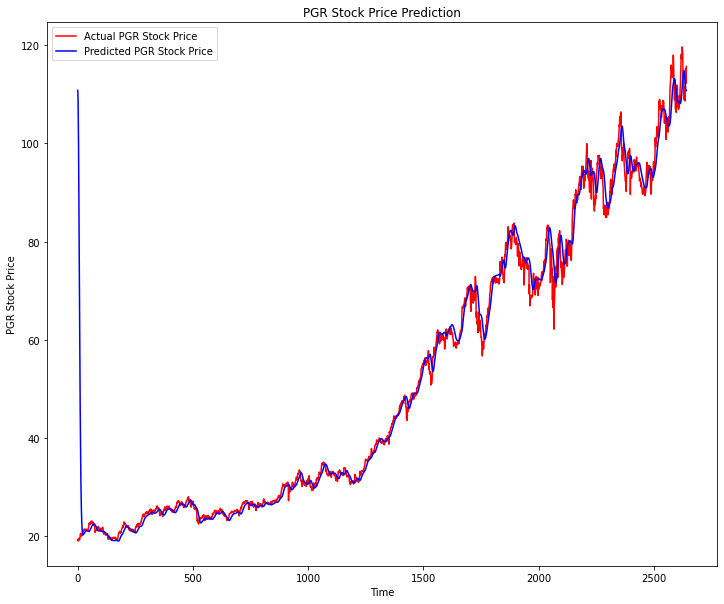

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(actual_stock_price, color='red', label = 'Actual PGR Stock Price')
plt.plot(predicted_stock_price, color='blue', label = 'Predicted PGR Stock Price')
plt.title('PGR Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('PGR Stock Price')
plt.legend()
plt.show()

In [ ]:
predicted_stock_price

array([[110.82509 ],
       [110.53218 ],
       [108.610725],
       ...,
       [110.83071 ],
       [110.732376],
       [110.75733 ]], dtype=float32)